In [1]:
import datetime
import pdb

import pandas as pd
import pyadcirc.data.noaa as noaa
import xarray as xa

In [2]:
noaa.NOAA_STATIONS

,Region,ID,Name
0,Alabama,8732828.0,"Weeks Bay, Mobile Bay"
1,Alabama,8735180.0,"Dauphin Island, AL"
2,Alabama,8735391.0,"Dog River Bridge, AL"
3,Alabama,8735523.0,"East Fowl River Bridge, AL"
4,Alabama,8736897.0,"Coast Guard Sector Mobile, AL"
...,...,...,...
291,Washington,9445958.0,"Bremerton, WA"
292,Washington,9446484.0,"Tacoma, WA"
293,Washington,9447130.0,"Seattle, WA"
294,Washington,9449424.0,"Cherry Point, WA"


In [3]:
ak_stations = noaa.NOAA_STATIONS[noaa.NOAA_STATIONS["Region"] == "Alaska"]
ak_stations.iloc[0:10]

,Region,ID,Name
9,Alaska,9450460.0,"Ketchikan, AK"
10,Alaska,9451054.0,"Port Alexander, AK"
11,Alaska,9451600.0,"Sitka, AK"
12,Alaska,9452210.0,"Juneau, AK"
13,Alaska,9452400.0,"Skagway, Taiya Inlet, AK"
14,Alaska,9452634.0,"Elfin Cove, AK"
15,Alaska,9453220.0,"Yakutat, Yakutat Bay, AK"
16,Alaska,9454050.0,"Cordova, AK"
17,Alaska,9454240.0,"Valdez, AK"
18,Alaska,9455090.0,"Seward, AK"


In [10]:
# pandas dataframe - index using iloc if not searching on index key
first_station = ak_stations.iloc[0]
first_station["ID"]

9450460.0

In [11]:
noaa.get_station_metadata(int(first_station["ID"]))

{'name': 'Ketchikan', 'id': 9450460, 'coords': [228.373889, 55.331944]}

## Station URL

We can explore the station at the following link:

https://tidesandcurrents.noaa.gov/stationhome.html?id=9450460


In [5]:
station_link = (
    f"https://tidesandcurrents.noaa.gov/stationhome.html?id={int(first_station['ID'])}"
)
station_link

'https://tidesandcurrents.noaa.gov/stationhome.html?id=9450460'

## Getting station data

Lets see the main function that does this:

In [6]:
print(noaa.get_station_data.__doc__)


    Get station data

    Parameters
    ----------
    station_id : int
      Seven digit unique identifier for station.
    start_date : str
      String start date in either yyyyMMdd, yyyyMMdd HH:mm, MM/dd/yyyy,
      or MM/dd/yyyy HH:mm) format.
    end_date : str
      String end date in either yyyyMMdd, yyyyMMdd HH:mm, MM/dd/yyyy,
      or MM/dd/yyyy HH:mm) format.

    Returns
    -------
    water_level : xarray.DataArray
      xarray.DataArray with a `water_level` values over time for the given date
      range, in meters.

    Examples
    --------
    Pull a single data point:

    >>> data = get_station_data(9468756, '20200101 00:00', '20200101 00:01')
    >>> data.values
    array([-1.209])

    Bad station ID should return no data

    >>> data = get_station_data(1, '20200101 00:00', '20200101 00:01')
    >>> len(data)==0
    True
    


### Product Date Range Limit

Note there is a 31 day limit to the date range

In [14]:
station_id = int(first_station["ID"])
start_date = pd.to_datetime("20201201 00:00")
end_date = pd.to_datetime("20210102 00:01")
station_id, start_date, end_date, end_date - start_date

(9450460,
 Timestamp('2020-12-01 00:00:00'),
 Timestamp('2021-01-02 00:01:00'),
 Timedelta('32 days 00:01:00'))

In [9]:
station_data = noaa.get_station_data(station_id, start_date, end_date)
station_data

<xarray.DataArray (time: 0)>
array([], dtype=float64)
Coordinates:
  * time     (time) float64 
Attributes:
    begin_date:   2020-12-01 00:00:00
    end_date:     2021-01-02 00:01:00
    station:      9450460
    product:      water_level
    datum:        msl
    units:        meters
    time_zone:    gmt
    application:  utaustin_chg
    format:       csv
    api_url:      https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?
    web_url:      https://tidesandcurrents.noaa.gov/waterlevels.html?id=94504...
    description:  NOAA/NOS/CO-OPS Observed Water Levels

If we just shift the date back to be in the 31 day range:

In [15]:
end_date = pd.to_datetime("20210101 00:01")
day_length = (end_date - start_date).days
end_date, day_length

(Timestamp('2021-01-01 00:01:00'), 31)

In [11]:
station_data = noaa.get_station_data(station_id, start_date, end_date)
station_data

<xarray.DataArray 'water_levels' (time: 7441)>
array([0.51 , 0.383, 0.265, ..., 1.939, 1.833, 1.733])
Coordinates:
  * time     (time) datetime64[ns] 2020-12-01 2020-12-01T00:06:00 ... 2021-01-01
Attributes:
    begin_date:   2020-12-01 00:00:00
    end_date:     2021-01-01 00:01:00
    station:      9450460
    product:      water_level
    datum:        msl
    units:        meters
    time_zone:    gmt
    application:  utaustin_chg
    format:       csv
    api_url:      https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?
    web_url:      https://tidesandcurrents.noaa.gov/waterlevels.html?id=94504...
    description:  NOAA/NOS/CO-OPS Observed Water Levels

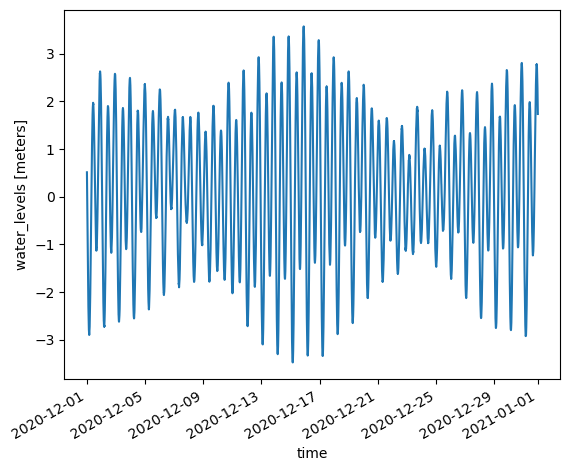

In [12]:
station_data.plot()

In [20]:
def scan_date_range(start_date, end_date, station_id, filter_rule=None, concat=True):
    """
    Scan Date Range

    Scan a date range for timestampes when water levels exceeded
    a certain threshold at a certain station
    """
    start_date = (
        start_date
        if isinstance(end_date, datetime.datetime)
        else pd.to_datetime(start_date)
    )
    end_date = (
        end_date
        if isinstance(end_date, datetime.datetime)
        else pd.to_datetime(end_date)
    )

    if filter_rule is None:
        filter_rule = lambda x: x
    else:
        if not callable(filter_fun):
            raise ValueError("Filter rule specified is not a function")

    def _pull_data(st, et):
        """Should always pull"""
        print(f"Getting chunk {st} - {et}")
        chunk = filter_rule(noaa.get_station_data(station_id, st, et))
        print(f"Pullled {len(chunk['time'])} records")
        return chunk

    def _recurse_help(sd, ed):
        d = (ed - sd).days
        print(f"Scanning date range {sd} - {ed} = {d} Days")
        if d <= 31:
            return [_pull_data(sd, ed)]
        else:
            chunk_end = sd + pd.to_timedelta(31, "D")
            return [_pull_data(sd, chunk_end)] + _recurse_help(chunk_end, ed)

    data = _recurse_help(start_date, end_date)
    if concat:
        data = xa.concat(data, dim="time")

    return data

Scanning date range 2020-12-01 00:00:00 - 2021-01-02 00:01:00 = 32 Days
Getting chunk 2020-12-01 00:00:00 - 2021-01-01 00:00:00
Pullled 7441 records
Scanning date range 2021-01-01 00:00:00 - 2021-01-02 00:01:00 = 1 Days
Getting chunk 2021-01-01 00:00:00 - 2021-01-02 00:01:00
Pullled 241 records


<xarray.DataArray 'water_levels' (time: 7682)>
array([0.51 , 0.383, 0.265, ..., 2.678, 2.612, 2.553])
Coordinates:
  * time     (time) datetime64[ns] 2020-12-01 2020-12-01T00:06:00 ... 2021-01-02
Attributes:
    begin_date:   2020-12-01 00:00:00
    end_date:     2021-01-01 00:00:00
    station:      9450460
    product:      water_level
    datum:        msl
    units:        meters
    time_zone:    gmt
    application:  utaustin_chg
    format:       csv
    api_url:      https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?
    web_url:      https://tidesandcurrents.noaa.gov/waterlevels.html?id=94504...
    description:  NOAA/NOS/CO-OPS Observed Water Levels

In [23]:
end_date = pd.to_datetime("20210101 00:01")
end_date = pd.to_datetime("20220101 00:01")
data = scan_date_range(start_date, end_date, station_id)
data

Scanning date range 2020-12-01 00:00:00 - 2022-01-01 00:01:00 = 396 Days
Getting chunk 2020-12-01 00:00:00 - 2021-01-01 00:00:00
Pullled 7441 records
Scanning date range 2021-01-01 00:00:00 - 2022-01-01 00:01:00 = 365 Days
Getting chunk 2021-01-01 00:00:00 - 2021-02-01 00:00:00
Pullled 7441 records
Scanning date range 2021-02-01 00:00:00 - 2022-01-01 00:01:00 = 334 Days
Getting chunk 2021-02-01 00:00:00 - 2021-03-04 00:00:00
Pullled 7441 records
Scanning date range 2021-03-04 00:00:00 - 2022-01-01 00:01:00 = 303 Days
Getting chunk 2021-03-04 00:00:00 - 2021-04-04 00:00:00
Pullled 7441 records
Scanning date range 2021-04-04 00:00:00 - 2022-01-01 00:01:00 = 272 Days
Getting chunk 2021-04-04 00:00:00 - 2021-05-05 00:00:00
Pullled 7441 records
Scanning date range 2021-05-05 00:00:00 - 2022-01-01 00:01:00 = 241 Days
Getting chunk 2021-05-05 00:00:00 - 2021-06-05 00:00:00
Pullled 7441 records
Scanning date range 2021-06-05 00:00:00 - 2022-01-01 00:01:00 = 210 Days
Getting chunk 2021-06-05 00

<xarray.DataArray 'water_levels' (time: 95053)>
array([ 0.51 ,  0.383,  0.265, ..., -1.811, -1.915, -2.024])
Coordinates:
  * time     (time) datetime64[ns] 2020-12-01 2020-12-01T00:06:00 ... 2022-01-01
Attributes:
    begin_date:   2020-12-01 00:00:00
    end_date:     2021-01-01 00:00:00
    station:      9450460
    product:      water_level
    datum:        msl
    units:        meters
    time_zone:    gmt
    application:  utaustin_chg
    format:       csv
    api_url:      https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?
    web_url:      https://tidesandcurrents.noaa.gov/waterlevels.html?id=94504...
    description:  NOAA/NOS/CO-OPS Observed Water Levels

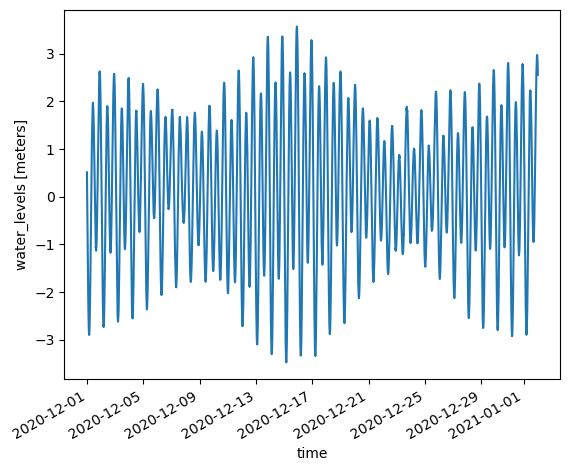

In [22]:
data.plot()

In [46]:
import importlib

importlib.reload(noaa)

<module 'pyadcirc.data.noaa' from '/home/jovyan/work/repos/pyadcirc/src/pyadcirc/data/noaa.py'>

In [48]:
query_res = noaa.noaa_query(station_id, start_date, end_date, "water_level")
query_res

HTTPError: 400 Client Error: Bad Request for url: https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=2020-12-01+00%3A00%3A00&end_date=2021-01-01+00%3A01%3A00&station=9450460&product=water_level

In [40]:
# params = {'begin_date': '20250801',
#           'end_date': '20250831',
#           'station': '8557863'
#           'product': predictions,
#           'datum': =MLLW&time_zone=lst_ldt&interval=hilo&units=english&application=DataAPI_Sample&format=xml
test = noaa.requests.get(
    "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20250801&end_date=20250831&station=8557863&product=predictions&datum=MLLW&time_zone=lst_ldt&interval=hilo&units=english&application=DataAPI_Sample&format=xml"
)
test.response

AttributeError: 'Response' object has no attribute 'response'